# 삼성 DS-KAIST AI Expert 프로그램
- 강의: 신진우 교수님
- 조교: 김재형 (jaehyungkim@kaist.ac.kr)

본 실습은 https://github.com/DetectionTeamUCAS/FPN_Tensorflow 에 기반하여 작성되었습니다.

---

# Object Detection

Image classification은 이미지 하나에 대해서 하나의 label을 예측하는 반면, object detection은 이미지 내의 모든 객체에 대해서 적합한 bounding box를 계산하고 (localization), 동시에 어떤 category에 속하는지 분류하는 (classification) 문제입니다. 

본 실습에서는 TensorFlow 프레임워크를 이용하여, object detection을 위한 neural network를 구현해보고, 이를 통해 테스트 이미지에 대한 object detection을 진행해볼 예정입니다. 

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
if type(tf.contrib) != type(tf): tf.contrib._warning = None
import tensorflow.contrib.slim as slim
import os, sys
import numpy as np
import argparse
import time
import cv2
sys.path.append("../")

from libs.networks import resnet
from libs.networks import mobilenet_v2
from libs.box_utils import encode_and_decode
from libs.box_utils import boxes_utils
from libs.box_utils import anchor_utils
from libs.configs import cfgs
from libs.losses import losses
from libs.box_utils import show_box_in_tensor
from libs.box_utils import draw_box_in_img
from libs.detection_oprations.proposal_opr import postprocess_rpn_proposals
from libs.detection_oprations.anchor_target_layer_without_boxweight import anchor_target_layer
from libs.detection_oprations.proposal_target_layer import proposal_target_layer

from data.io.read_tfrecord import next_batch
from data.io.image_preprocess import short_side_resize_for_inference_data

from help_utils import tools

os.environ["CUDA_VISIBLE_DEVICES"] = cfgs.GPU_GROUP
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--
/home/jaehyung/workspace/Samsung/FPN_Tensorflow


# Faster R-CNN with FPN

본 실습에서 저희는 앞서 강의에서 다루었던 two-stage detector 중 하나인 Faster R-CNN (Ren et al., 2015)를 구현해볼 것입니다. 
Faster R-CNN에서 임의의 이미지에 대한 object detection은 다음과 같이 진행되며, 저희는 이를 순서대로 직접 구현해볼 것입니다.

1. 사전에 학습된 backbone network $f$ 를 이용하여 주어진 이미지 $x$에 대한 feature map $f(x)$를 얻습니다.
   (저희는 이미지넷에서 사전학습된 ResNet-50을 사용합니다.)
2. 앞서 얻은 이미지 feature map $f(x)$를 `Region Proposal Network (RPN)` 에 통과시킴으로써, 해당 이미지에 내에서 object가 있을 가능성이    높은 후보군인 `Region of Interests (RoIs)` 를 생성합니다.  
3. 각각의 `RoI` 에 대한 classification 및 추가적인 bounding box 정교화(localization)를 위해, 주어진 `RoI` 에 해당하는 feature map      $f(x)$ 의 영역을 `RoI pooling` 을 통해 구합니다.
4. 구해진 `RoI` feature map을 이용하여 classification 및 bounding box 좌표를 계산합니다. 이는 Fast R-CNN (Ross Girshick, 2015)에      해당하는 부분으로 생각할 수 있습니다.   

<img src="https://www.researchgate.net/profile/Zhipeng_Deng/publication/324903264/figure/fig2/AS:640145124499471@1529633899620/The-architecture-of-Faster-R-CNN.png">

# Feature Extraction with Backbone Network  



In [2]:
def build_base_network(input_img_batch, base_network_name, is_training=False):
    if base_network_name.startswith('resnet_v1'):
        return resnet.resnet_base(input_img_batch, scope_name=base_network_name, is_training=is_training)
    else:
        raise ValueError('Sry, we only support resnet')

# [Task 1] Region Proposal Network (RPN) 

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F992805365B46F812147056">

아래에 주어진 함수를 적절히 활용하여 RPN을 구현해보세요.
(단, 그림에서 256-d를 사용한 것과 달리 저희는 512-d를 사용하겠습니다.)
- `slim.conv2d(x, p, [k,k], ...)`: For input x, output a feature with p channels using convolution filter of size k
- `slim.softmax(x, ...)`: Get a probability from x using a softmax
- `tf.reshape(x, [-1, b])`: Reshape a tensor x to be a tensor with shape [-1, b] => using it, make ith row mean ith RoI

In [3]:
def RPN(feature_maps, num_anchors_per_location, is_training=False, reuse_flag=False):
    '''
    feature_maps: feature map of given image
    num_anchors_per_location: # of anchors per each location
    '''
    rpn_conv3x3 = slim.conv2d(
                    feature_maps, 512, [3, 3],
                    trainable=is_training, weights_initializer=cfgs.INITIALIZER, padding="SAME",
                    activation_fn=tf.nn.relu,
                    scope='rpn_conv/3x3',
                    reuse=reuse_flag)
    rpn_cls_score = slim.conv2d(rpn_conv3x3, num_anchors_per_location*2, [1, 1], stride=1,
                                            trainable=is_training, weights_initializer=cfgs.INITIALIZER,
                                            activation_fn=None, padding="VALID",
                                            scope='rpn_cls_score',
                                            reuse=reuse_flag)
    rpn_box_pred = slim.conv2d(rpn_conv3x3, num_anchors_per_location*4, [1, 1], stride=1,
                                           trainable=is_training, weights_initializer=cfgs.BBOX_INITIALIZER,
                                           activation_fn=None, padding="VALID",
                                           scope='rpn_bbox_pred',
                                           reuse=reuse_flag)
    rpn_box_pred = tf.reshape(rpn_box_pred, [-1, 4])
    rpn_cls_score = tf.reshape(rpn_cls_score, [-1, 2])
    rpn_cls_prob = slim.softmax(rpn_cls_score, scope='rpn_cls_prob')
    
    return rpn_cls_prob, rpn_box_pred

# [Task 2] RoI Pooling  

아래에 주어진 함수를 적절히 활용하여 다음 함수의 빈칸을 채우고, RoI Pooling 구현을 완성해주세요.
- [`tf.image.crop_and_resize`](https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize): Using this function, resize each RoIs to be 14x14
- `slim.max_pool2d(x, [k, k], stride=s)`: Max-pooling of feature x with kernel size k and stride s => Make 7x7 final features

In [4]:
def roi_pooling(feature_maps, rois, img_shape, scope):
    '''
    feature_maps: feature map to be cropped
    rois: shape is [-1, 4]. [x1, y1, x2, y2]
    img_shape: 3 x h x w
    '''
    with tf.compat.v1.variable_scope('ROI_Warping_' + scope):
        img_h, img_w = tf.cast(img_shape[1], tf.float32), tf.cast(img_shape[2], tf.float32)
        N = tf.shape(rois)[0]
        x1, y1, x2, y2 = tf.unstack(rois, axis=1) 
        
        normalized_x1 = x1 / img_w
        normalized_x2 = x2 / img_w
        normalized_y1 = y1 / img_h
        normalized_y2 = y2 / img_h

        # normalized_rois: (0,1) scaled positions of rois 
        normalized_rois = tf.transpose(tf.stack([normalized_y1, normalized_x1, normalized_y2, normalized_x2]), name='get_normalized_rois')
        normalized_rois = tf.stop_gradient(normalized_rois)

        cropped_roi_features = tf.image.crop_and_resize(feature_maps, normalized_rois, box_ind=tf.zeros(shape=[N, ],
                                                            dtype=tf.int32), crop_size=[14, 14], name='CROP_AND_RESIZE')
        roi_features = slim.max_pool2d(cropped_roi_features, [2, 2], stride=2)
    return roi_features

# [Task 3] Fast R-CNN 

아래에 주어진 함수를 적절히 활용하여 다음 함수의 빈칸을 채우고, Fast R-CNN을 구현해보세요.
- `roi_pooling`: RoI pooling layer from [Task 2]
- `resnet.resnet_head(inputs=x, ...)`: fully connected network for flattening a given input x (feature map)
- `slim.fully_connected(x, num_outputs=k, ...)`: fully connected network (input:x, output:k)

In [5]:
def build_fastrcnn(feature_map, rois, img_shape, level_name, base_network_name, is_training=False):
    with tf.compat.v1.variable_scope('Fast-RCNN'):
        # ROI Pooling
        with tf.compat.v1.variable_scope('rois_pooling'):
            pooled_features = roi_pooling(feature_maps=feature_map, rois=rois, img_shape=img_shape, scope=level_name)
                    
        # inferecne rois in Fast-RCNN to obtain fc_flatten features
        if base_network_name.startswith('resnet'):
            fc_flatten = resnet.restnet_head(inputs=pooled_features, is_training=is_training, scope_name=base_network_name)
        else:
            raise NotImplementedError('only support resnet')

        # cls and reg in Fast-RCNN
        with slim.arg_scope([slim.fully_connected], weights_regularizer=slim.l2_regularizer(cfgs.WEIGHT_DECAY)):
            cls_score = slim.fully_connected(fc_flatten, num_outputs=cfgs.CLASS_NUM+1, weights_initializer=cfgs.INITIALIZER,
                                             activation_fn=None, trainable=is_training, scope='cls_fc')
            bbox_pred = slim.fully_connected(fc_flatten, num_outputs=(cfgs.CLASS_NUM+1)*4, weights_initializer=cfgs.BBOX_INITIALIZER,
                                             activation_fn=None, trainable=is_training, scope='reg_fc')
                
            cls_score = tf.reshape(cls_score, [-1, cfgs.CLASS_NUM+1])
            bbox_pred = tf.reshape(bbox_pred, [-1, 4*(cfgs.CLASS_NUM+1)])
            cls_prob = slim.softmax(cls_score, 'cls_prob')

            return bbox_pred, cls_prob

# Faster R-CNN

앞서 구현한 함수들을 이용하여, 아래와 같이 Faster R-CNN을 구현할 수 있습니다.

In [19]:
class Faster_RCNN(object):
    def __init__(self, base_network_name, layer_idx=4, is_training=False):
        self.base_network_name = base_network_name
        self.layer_idx = layer_idx
        self.is_training = is_training
        self.num_anchors_per_location = len(cfgs.ANCHOR_SCALES) * len(cfgs.ANCHOR_RATIOS)

    def build_whole_detection_network(self, input_img_batch, gtboxes_batch):
        img_shape = tf.shape(input_img_batch)

        # 1. build base network
        P_list = build_base_network(input_img_batch, self.base_network_name)  # Multi-scale features:[P2, P3, P4, P5, P6]

        # 2. build rpn
        with tf.compat.v1.variable_scope('build_rpn', regularizer=slim.l2_regularizer(cfgs.WEIGHT_DECAY)):
            level_name, p = cfgs.LEVLES[self.layer_idx], P_list[self.layer_idx]    
            rpn_cls_prob, rpn_box_pred = RPN(p, self.num_anchors_per_location)
            
        # 3. generate_anchors
        p_h, p_w = tf.shape(p)[1], tf.shape(p)[2]
        featuremap_height = tf.cast(p_h, tf.float32)
        featuremap_width = tf.cast(p_w, tf.float32)
        anchors = anchor_utils.make_anchors(base_anchor_size=cfgs.BASE_ANCHOR_SIZE_LIST[self.layer_idx],
                                            anchor_scales=cfgs.ANCHOR_SCALES,
                                            anchor_ratios=cfgs.ANCHOR_RATIOS,
                                            featuremap_height=featuremap_height,
                                            featuremap_width=featuremap_width,
                                            stride=cfgs.ANCHOR_STRIDE_LIST[self.layer_idx],
                                            name="make_anchors_for%s" % level_name)
        
        # 4. postprocess rpn proposals. such as: decode, clip, NMS
        with tf.compat.v1.variable_scope('postprocess_RPN'):
            rois, roi_scores = postprocess_rpn_proposals(rpn_bbox_pred=rpn_box_pred,
                                                         rpn_cls_prob=rpn_cls_prob,
                                                         img_shape=img_shape,
                                                         anchors=anchors,
                                                         is_training=self.is_training)
        
        # 5. build Fast-RCNN
        bbox_pred, cls_prob = build_fastrcnn(feature_map=p, rois=rois, img_shape=img_shape, 
                                             level_name=level_name, base_network_name=self.base_network_name)
        
        #  6. postprocess_fastrcnn
        final_boxes, final_scores, final_category = self.postprocess_fastrcnn(rois=rois, 
                                                                              bbox_ppred=bbox_pred, 
                                                                              scores=cls_prob, 
                                                                              img_shape=img_shape)
        
        return final_boxes, final_scores, final_category
    
    ######################################## Utility functions (do not disturb!) ########################################
    
    ## Goal: post-processing after inference  
    def postprocess_fastrcnn(self, rois, bbox_ppred, scores, img_shape):
        '''
        rois:[-1, 4], bbox_ppred: [-1, (cfgs.Class_num+1) * 4], scores: [-1, cfgs.Class_num + 1]
        '''
        with tf.name_scope('postprocess_fastrcnn'):
            rois = tf.stop_gradient(rois)
            scores = tf.stop_gradient(scores)
            bbox_ppred = tf.reshape(bbox_ppred, [-1, cfgs.CLASS_NUM + 1, 4])
            bbox_ppred = tf.stop_gradient(bbox_ppred)

            bbox_pred_list = tf.unstack(bbox_ppred, axis=1)
            score_list = tf.unstack(scores, axis=1)

            allclasses_boxes = []
            allclasses_scores = []
            categories = []
            
            for i in range(1, cfgs.CLASS_NUM+1):

                # 1. decode boxes in each class
                tmp_encoded_box = bbox_pred_list[i]
                tmp_score = score_list[i]
                tmp_decoded_boxes = encode_and_decode.decode_boxes(encoded_boxes=tmp_encoded_box,
                                                                   reference_boxes=rois,
                                                                   scale_factors=cfgs.ROI_SCALE_FACTORS)
                
                # 2. clip to img boundaries
                tmp_decoded_boxes = boxes_utils.clip_boxes_to_img_boundaries(decode_boxes=tmp_decoded_boxes,
                                                                             img_shape=img_shape)

                # 3. NMS
                keep = tf.image.non_max_suppression(
                    boxes=tmp_decoded_boxes,
                    scores=tmp_score,
                    max_output_size=cfgs.FAST_RCNN_NMS_MAX_BOXES_PER_CLASS,
                    iou_threshold=cfgs.FAST_RCNN_NMS_IOU_THRESHOLD)

                perclass_boxes = tf.gather(tmp_decoded_boxes, keep)
                perclass_scores = tf.gather(tmp_score, keep)

                allclasses_boxes.append(perclass_boxes)
                allclasses_scores.append(perclass_scores)
                categories.append(tf.ones_like(perclass_scores) * i)

            final_boxes = tf.concat(allclasses_boxes, axis=0)
            final_scores = tf.concat(allclasses_scores, axis=0)
            final_category = tf.concat(categories, axis=0)

            if self.is_training:
                '''
                For a visualization in the tensorboard
                '''
                kept_indices = tf.reshape(tf.where(tf.greater_equal(final_scores, cfgs.SHOW_SCORE_THRSHOLD)), [-1])

                final_boxes = tf.gather(final_boxes, kept_indices)
                final_scores = tf.gather(final_scores, kept_indices)
                final_category = tf.gather(final_category, kept_indices)

        return final_boxes, final_scores, final_category

    # Goal: load pre-trained parameters  
    def get_restorer(self):
        checkpoint_path = tf.train.latest_checkpoint(os.path.join(cfgs.TRAINED_CKPT, cfgs.VERSION))

        if checkpoint_path != None:
            restorer = tf.compat.v1.train.Saver()
            print("model restore from :", checkpoint_path)
        else:
            ValueError('Sry, we cannot restore the model from a given path')
        return restorer, checkpoint_path

## Demo

이제, 학습된 모델을 이용하여 실제 테스트 이미지에 대한 객체 검출을 진행해볼 것입니다.

In [7]:
def detect(det_net, inference_save_path, real_test_imgname_list):
    # Preprocess img
    img_plac = tf.placeholder(dtype=tf.uint8, shape=[None, None, 3])
    img_batch = tf.cast(img_plac, tf.float32)
    img_batch = short_side_resize_for_inference_data(img_tensor=img_batch,
                                                     target_shortside_len=cfgs.IMG_SHORT_SIDE_LEN,
                                                     length_limitation=cfgs.IMG_MAX_LENGTH)
    img_batch = img_batch - tf.constant(cfgs.PIXEL_MEAN)
    img_batch = tf.expand_dims(img_batch, axis=0)

    # Object detection
    detection_boxes, detection_scores, detection_category = det_net.build_whole_detection_network(
        input_img_batch=img_batch, gtboxes_batch=None)

    init_op = tf.group(
        tf.global_variables_initializer(),
        tf.local_variables_initializer()
    )

    # Load pre-trained parameters
    restorer, restore_ckpt = det_net.get_restorer()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(init_op)
        if not restorer is None:
            restorer.restore(sess, restore_ckpt)
            print('restore model')

        for i, a_img_name in enumerate(real_test_imgname_list):
            raw_img = cv2.imread(a_img_name)
            start = time.time()
            resized_img, detected_boxes, detected_scores, detected_categories = \
                sess.run(
                    [img_batch, detection_boxes, detection_scores, detection_category],
                    feed_dict={img_plac: raw_img[:, :, ::-1]}
                )
            end = time.time()
            
            show_indices = detected_scores >= cfgs.SHOW_SCORE_THRSHOLD
            show_scores = detected_scores[show_indices]
            show_boxes = detected_boxes[show_indices]
            show_categories = detected_categories[show_indices]
            final_detections = draw_box_in_img.draw_boxes_with_label_and_scores(np.squeeze(resized_img, 0),
                                                                                boxes=show_boxes,
                                                                                labels=show_categories,
                                                                                scores=show_scores)
            nake_name = a_img_name.split('/')[-1]
            cv2.imwrite(inference_save_path + '/' + nake_name, final_detections[:, :, ::-1])
            tools.view_bar('{} image cost {}s'.format(a_img_name, (end - start)), i + 1, len(real_test_imgname_list))

In [9]:
def inference(test_dir, inference_save_path):
    test_imgname_list = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)
                                                          if img_name.endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]
    assert len(test_imgname_list) != 0, 'test_dir has no imgs there.' \
                                        ' Note that, we only support img format of (.jpg, .png, and .tiff) '

    faster_rcnn = Faster_RCNN(base_network_name=cfgs.NET_NAME)

    detect(det_net=faster_rcnn, inference_save_path=inference_save_path, real_test_imgname_list=test_imgname_list)

In [10]:
tf.reset_default_graph()
data_dir = './demos'
save_dir = './inference_results'
inference(data_dir, save_dir)


model restore from : /home/jaehyung/workspace/Samsung/FPN_Tensorflow/output/trained_weights/FPN_Res50_20181201/voc_190000model.ckpt
INFO:tensorflow:Restoring parameters from /home/jaehyung/workspace/Samsung/FPN_Tensorflow/output/trained_weights/FPN_Res50_20181201/voc_190000model.ckpt
restore model
./demos/03.jpg image cost 0.06014060974121094s:[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100%	13/13

# Object Detection 결과 확인
각 테스트 이미지에 대해 생성된 bounding box와 이에 대한 classification 결과를 직접 확인해보세요.
- 이미지: '01~13.jpg'

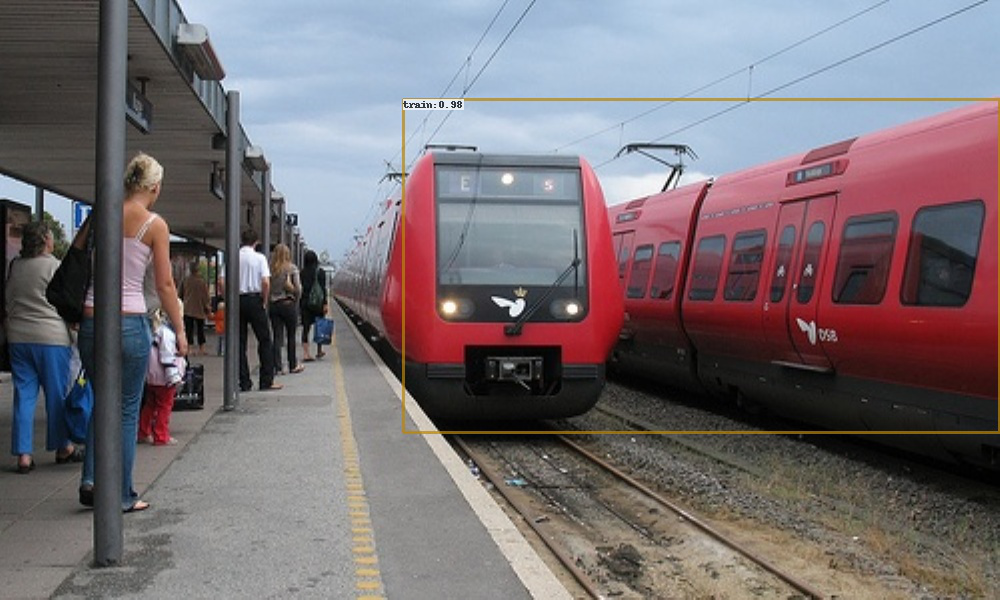

In [11]:
from PIL import Image
Image.open('./inference_results/07.jpg')

# [Task 4] Object Detection for Small Objective

앞서 구현된 Faster R-CNN을 이용한 object detection의 경우 크기가 큰 물체들은 잘 검출되는 반면, 상대적으로 크기가 작은 물체들의 검출률이 상대적으로 떨어진다는 점을 위의 이미지들을 통해서 직접 확인하실 수 있으셨을 겁니다. 이는, 저희가 앞서 사용한 RPN이 현재 크기가 작은 물체들에 대해 RoIs 생성을 제대로 하지 못하기 때문입니다. 이를 해결하기 위해, 위의 `Faster_RCNN` 코드를 다시 한번 확인하시고, 간단한 수정을 통해 저희의 Faster R-CNN이 크기가 작은 물체들을 검출해낼 수 있도록 만들어주세요.

In [13]:
tf.reset_default_graph()
data_dir = './demos'
save_dir = './inference_results_small'
inference(data_dir, save_dir)

model restore from : /home/jaehyung/workspace/Samsung/FPN_Tensorflow/output/trained_weights/FPN_Res50_20181201/voc_190000model.ckpt
INFO:tensorflow:Restoring parameters from /home/jaehyung/workspace/Samsung/FPN_Tensorflow/output/trained_weights/FPN_Res50_20181201/voc_190000model.ckpt
restore model
./demos/03.jpg image cost 0.04699969291687012s:[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100%	13/13

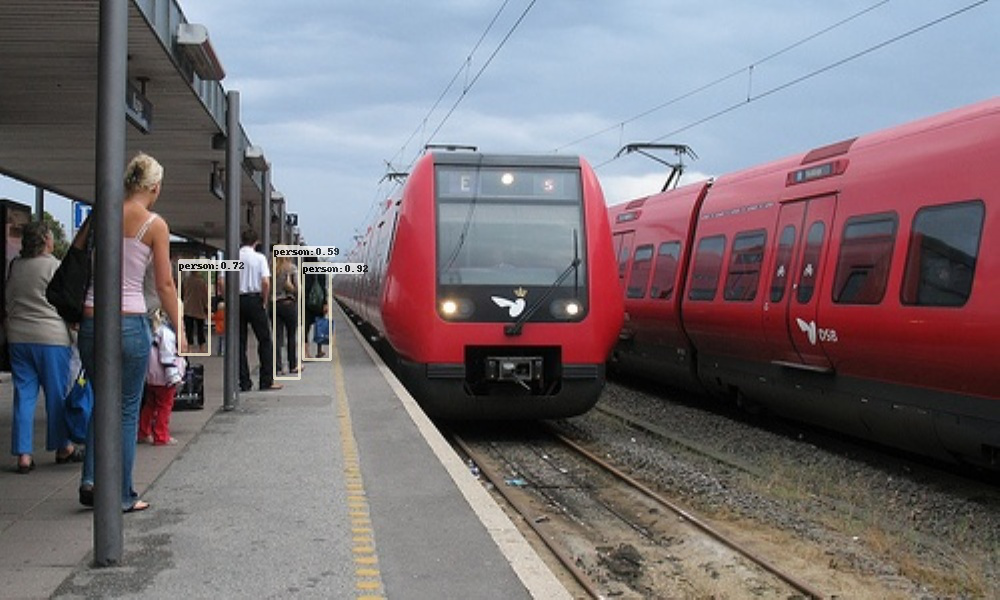

In [14]:
Image.open('./inference_results_small/07.jpg')

# [Task 5] Feature Pyramid Network (FPN)

low level feature에서 RoIs를 추출함으로써 상대적으로 작은 물체까지 검출할 수 있음을 확인해보았습니다. 하지만, 이와 동시에, 큰 물체에 대한 검출률은 감소하였음을 확인하실 수 있으셨을텐데요, 이를 동시에 개선할 수 있는 방법이 앞서 강의 시간에서도 다루었던 FPN (Lin et al., 2016) 입니다. FPN은 multi-scale feature에서 동시에 RoIs를 생성하고, fast R-CNN을 통한 inference시에도 이를 활용함으로써 다양한 스케일의 물체 검출을 가능케 했는데요, 아래의 주어진 함수를 적절히 활용하여 FPN의 구현을 마무리해주세요. 

(1) self.build_fastrcnn 내의 pooled_features 완성하기

(2) build_whole_detection_network 내의 RPN 부분 완성하기

- `tf.concat(list, axis=d)` : list내의 tensor들을 모아 d axis에 대한 concatenation 실행 
- `list.append(x)` : element x를 list에 삽입

<img src="https://www.researchgate.net/publication/338363188/figure/fig1/AS:843281365737472@1578065353313/Framework-of-our-object-detection-in-remote-sensing-images-ODRSIs-method-a-feature.png">

In [15]:
class FPN(object):
    def __init__(self, base_network_name, is_training=False):
        self.base_network_name = base_network_name
        self.is_training = is_training
        self.num_anchors_per_location = len(cfgs.ANCHOR_SCALES) * len(cfgs.ANCHOR_RATIOS)

    def build_fastrcnn(self, P_list, rois_list, img_shape):
        with tf.compat.v1.variable_scope('Fast-RCNN'):
            # ROI Pooling
            with tf.compat.v1.variable_scope('rois_pooling'):
                pooled_features_list = []
                for level_name, p, rois in zip(cfgs.LEVLES, P_list, rois_list):  
                    pooled_feature = roi_pooling(feature_maps=p, rois=rois, img_shape=img_shape, scope=level_name)
                    pooled_features_list.append(pooled_feature)

                pooled_features = tf.concat(pooled_features_list, axis=0) # [minibatch_size, H, W, C]

            # inferecne rois in Fast-RCNN to obtain fc_flatten features
            if self.base_network_name.startswith('resnet'):
                fc_flatten = resnet.restnet_head(inputs=pooled_features, is_training=self.is_training, scope_name=self.base_network_name)
            else:
                raise NotImplementedError('only support resnet')

            # cls and reg in Fast-RCNN
            with slim.arg_scope([slim.fully_connected], weights_regularizer=slim.l2_regularizer(cfgs.WEIGHT_DECAY)):
                cls_score = slim.fully_connected(fc_flatten, num_outputs=cfgs.CLASS_NUM+1, weights_initializer=cfgs.INITIALIZER,
                                                 activation_fn=None, trainable=self.is_training, scope='cls_fc')
                bbox_pred = slim.fully_connected(fc_flatten, num_outputs=(cfgs.CLASS_NUM+1)*4, weights_initializer=cfgs.BBOX_INITIALIZER,
                                                 activation_fn=None, trainable=self.is_training, scope='reg_fc')
                
                cls_score = tf.reshape(cls_score, [-1, cfgs.CLASS_NUM+1])
                bbox_pred = tf.reshape(bbox_pred, [-1, 4*(cfgs.CLASS_NUM+1)])
                cls_prob = slim.softmax(cls_score, 'cls_prob')

                return bbox_pred, cls_prob

    def build_whole_detection_network(self, input_img_batch, gtboxes_batch):
        img_shape = tf.shape(input_img_batch)

        # 1. build base network
        P_list = build_base_network(input_img_batch, self.base_network_name)

        # 2. build rpn
        with tf.compat.v1.variable_scope('build_rpn', regularizer=slim.l2_regularizer(cfgs.WEIGHT_DECAY)):
            fpn_cls_prob =[]
            fpn_box_pred = []
            for level_name, p in zip(cfgs.LEVLES, P_list):
                reuse_flag = None if level_name==cfgs.LEVLES[0] else True
                
                rpn_cls_prob, rpn_box_pred = RPN(p, self.num_anchors_per_location, self.is_training, reuse_flag)

                fpn_cls_prob.append(rpn_cls_prob)
                fpn_box_pred.append(rpn_box_pred)

            fpn_cls_prob = tf.concat(fpn_cls_prob, axis=0, name='fpn_cls_prob')
            fpn_box_pred = tf.concat(fpn_box_pred, axis=0, name='fpn_box_pred')

        # 3. generate_anchors
        all_anchors = []
        for i in range(len(cfgs.LEVLES)):
            level_name, p = cfgs.LEVLES[i], P_list[i]

            p_h, p_w = tf.shape(p)[1], tf.shape(p)[2]
            featuremap_height = tf.cast(p_h, tf.float32)
            featuremap_width = tf.cast(p_w, tf.float32)
            anchors = anchor_utils.make_anchors(base_anchor_size=cfgs.BASE_ANCHOR_SIZE_LIST[i],
                                                anchor_scales=cfgs.ANCHOR_SCALES,
                                                anchor_ratios=cfgs.ANCHOR_RATIOS,
                                                featuremap_height=featuremap_height,
                                                featuremap_width=featuremap_width,
                                                stride=cfgs.ANCHOR_STRIDE_LIST[i],
                                                name="make_anchors_for%s" % level_name)
            all_anchors.append(anchors)
        all_anchors = tf.concat(all_anchors, axis=0, name='all_anchors_of_FPN')

        # 4. postprocess rpn proposals. such as: decode, clip, NMS
        with tf.compat.v1.variable_scope('postprocess_FPN'):
            rois, roi_scores = postprocess_rpn_proposals(rpn_bbox_pred=fpn_box_pred,
                                                         rpn_cls_prob=fpn_cls_prob,
                                                         img_shape=img_shape,
                                                         anchors=all_anchors,
                                                         is_training=self.is_training)
        
        rois_list = self.assign_levels(all_rois=rois)  # rois_list: [P2_rois, P3_rois, P4_rois, P5_rois]

        # 5. build Fast-RCNN
        bbox_pred, cls_prob = self.build_fastrcnn(P_list=P_list, rois_list=rois_list, img_shape=img_shape)
        rois = tf.concat(rois_list, axis=0, name='concat_rois')
        
        #  6. postprocess_fastrcnn
        final_boxes, final_scores, final_category = self.postprocess_fastrcnn(rois=rois, 
                                                                              bbox_ppred=bbox_pred, 
                                                                              scores=cls_prob, 
                                                                              img_shape=img_shape)
        
        return final_boxes, final_scores, final_category
    
    
    ######################################## Utility functions (do not disturb) ########################################
    
    ## Goal: post-processing after inference  
    def postprocess_fastrcnn(self, rois, bbox_ppred, scores, img_shape):
        '''
        rois:[-1, 4], bbox_ppred: [-1, (cfgs.Class_num+1) * 4], scores: [-1, cfgs.Class_num + 1]
        '''
        with tf.name_scope('postprocess_fastrcnn'):
            rois = tf.stop_gradient(rois)
            scores = tf.stop_gradient(scores)
            bbox_ppred = tf.reshape(bbox_ppred, [-1, cfgs.CLASS_NUM + 1, 4])
            bbox_ppred = tf.stop_gradient(bbox_ppred)

            bbox_pred_list = tf.unstack(bbox_ppred, axis=1)
            score_list = tf.unstack(scores, axis=1)

            allclasses_boxes = []
            allclasses_scores = []
            categories = []
            
            for i in range(1, cfgs.CLASS_NUM+1):

                # 1. decode boxes in each class
                tmp_encoded_box = bbox_pred_list[i]
                tmp_score = score_list[i]
                tmp_decoded_boxes = encode_and_decode.decode_boxes(encoded_boxes=tmp_encoded_box,
                                                                   reference_boxes=rois,
                                                                   scale_factors=cfgs.ROI_SCALE_FACTORS)
                
                # 2. clip to img boundaries
                tmp_decoded_boxes = boxes_utils.clip_boxes_to_img_boundaries(decode_boxes=tmp_decoded_boxes,
                                                                             img_shape=img_shape)

                # 3. NMS
                keep = tf.image.non_max_suppression(
                    boxes=tmp_decoded_boxes,
                    scores=tmp_score,
                    max_output_size=cfgs.FAST_RCNN_NMS_MAX_BOXES_PER_CLASS,
                    iou_threshold=cfgs.FAST_RCNN_NMS_IOU_THRESHOLD)

                perclass_boxes = tf.gather(tmp_decoded_boxes, keep)
                perclass_scores = tf.gather(tmp_score, keep)

                allclasses_boxes.append(perclass_boxes)
                allclasses_scores.append(perclass_scores)
                categories.append(tf.ones_like(perclass_scores) * i)

            final_boxes = tf.concat(allclasses_boxes, axis=0)
            final_scores = tf.concat(allclasses_scores, axis=0)
            final_category = tf.concat(categories, axis=0)

            if self.is_training:
                '''
                For a visualization in the tensorboard
                '''
                kept_indices = tf.reshape(tf.where(tf.greater_equal(final_scores, cfgs.SHOW_SCORE_THRSHOLD)), [-1])

                final_boxes = tf.gather(final_boxes, kept_indices)
                final_scores = tf.gather(final_scores, kept_indices)
                final_category = tf.gather(final_category, kept_indices)

        return final_boxes, final_scores, final_category
    
    ## Goal: assign a proper level for each RoI
    def assign_levels(self, all_rois, labels=None, bbox_targets=None):
        
        with tf.name_scope('assign_levels'):
            xmin, ymin, xmax, ymax = tf.unstack(all_rois, axis=1)

            h = tf.maximum(0., ymax - ymin)
            w = tf.maximum(0., xmax - xmin)

            levels = tf.floor(4. + tf.math.log(tf.sqrt(w * h + 1e-8) / 224.0) / tf.math.log(2.))  # 4 + log_2(***)
            # use floor instead of round

            min_level = int(cfgs.LEVLES[0][-1])
            max_level = min(5, int(cfgs.LEVLES[-1][-1]))
            levels = tf.maximum(levels, tf.ones_like(levels) * min_level)  # level minimum is 2
            levels = tf.minimum(levels, tf.ones_like(levels) * max_level)  # level maximum is 5
            levels = tf.stop_gradient(tf.reshape(levels, [-1]))

            def get_rois(levels, level_i, rois, labels, bbox_targets):

                level_i_indices = tf.reshape(tf.where(tf.equal(levels, level_i)), [-1])
                tf.compat.v1.summary.scalar('LEVEL/LEVEL_%d_rois_NUM'%level_i, tf.shape(level_i_indices)[0])
                level_i_rois = tf.gather(rois, level_i_indices)

                if self.is_training:
                    level_i_rois = tf.stop_gradient(level_i_rois)
                    level_i_labels = tf.gather(labels, level_i_indices)
                    level_i_targets = tf.gather(bbox_targets, level_i_indices)
                    
                    return level_i_rois, level_i_labels, level_i_targets
                else:
                    return level_i_rois, None, None

            rois_list = []
            labels_list = []
            targets_list = []
            
            for i in range(min_level, max_level+1):
                P_i_rois, P_i_labels, P_i_targets = get_rois(levels, level_i=i, rois=all_rois,
                                                             labels=labels,
                                                             bbox_targets=bbox_targets)
                rois_list.append(P_i_rois)
                labels_list.append(P_i_labels)
                targets_list.append(P_i_targets)

            return rois_list  # [P2_rois, P3_rois, P4_rois, P5_rois] Note: P6 do not assign rois

    ## Goal: load pre-trained parameters  
    def get_restorer(self):
        checkpoint_path = tf.train.latest_checkpoint(os.path.join(cfgs.TRAINED_CKPT, cfgs.VERSION))

        if checkpoint_path != None:
            restorer = tf.compat.v1.train.Saver()
            print("model restore from :", checkpoint_path)
        else:
            ValueError('Sry, we cannot restore the model from a given path')
        return restorer, checkpoint_path

In [16]:
def inference_fpn(test_dir, inference_save_path):
    test_imgname_list = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)
                                                          if img_name.endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]
    assert len(test_imgname_list) != 0, 'test_dir has no imgs there.' \
                                        ' Note that, we only support img format of (.jpg, .png, and .tiff) '

    fpn = FPN(base_network_name=cfgs.NET_NAME)
    detect(det_net=fpn, inference_save_path=inference_save_path, real_test_imgname_list=test_imgname_list)

In [17]:
tf.reset_default_graph()
data_dir = './demos'
save_dir = './inference_results_all'
inference_fpn(data_dir, save_dir)

model restore from : /home/jaehyung/workspace/Samsung/FPN_Tensorflow/output/trained_weights/FPN_Res50_20181201/voc_190000model.ckpt
INFO:tensorflow:Restoring parameters from /home/jaehyung/workspace/Samsung/FPN_Tensorflow/output/trained_weights/FPN_Res50_20181201/voc_190000model.ckpt
restore model
./demos/03.jpg image cost 0.05878496170043945s:[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100%	13/13

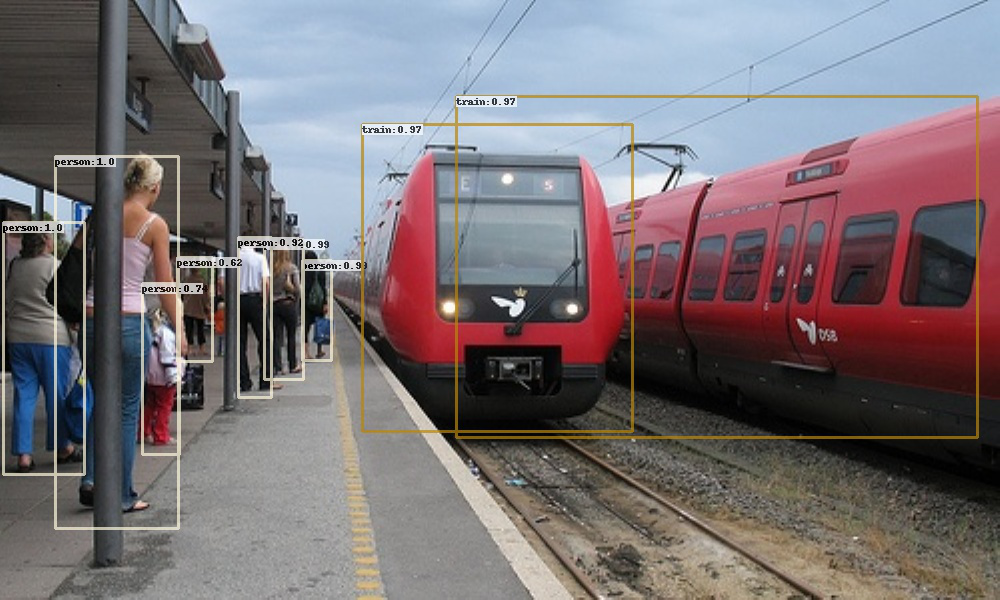

In [18]:
Image.open('./inference_results_all/07.jpg')